In [40]:
import numpy as np
import pandas as pd
# from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')
# import sklearn

In [41]:
import os

---

In [42]:
train  = pd.read_csv('./data/train.csv')
test  = pd.read_csv('./data/test.csv')

train = train.drop(['index'],axis = 1)
test =test.drop(['index'],axis = 1)

In [43]:
concat_features = train

mask = concat_features.introelapse > (concat_features.introelapse.quantile(0.75) + 1.5 * (concat_features.introelapse.quantile(0.75) - concat_features.introelapse.quantile(0.25)))
concat_features.introelapse[mask] = concat_features.introelapse.quantile(0.75)

mask = concat_features.testelapse > (concat_features.testelapse.quantile(0.75) + 1.5 * (concat_features.testelapse.quantile(0.75) - concat_features.testelapse.quantile(0.25)))
concat_features.testelapse[mask] = concat_features.testelapse.quantile(0.75)

mask = concat_features.surveyelapse > (concat_features.surveyelapse.quantile(0.75) + 1.5 * (concat_features.surveyelapse.quantile(0.75) - concat_features.surveyelapse.quantile(0.25)))
concat_features.surveyelapse[mask] = concat_features.surveyelapse.quantile(0.75)

train = concat_features



concat_features = test

mask = concat_features.introelapse > (concat_features.introelapse.quantile(0.75) + 1.5 * (concat_features.introelapse.quantile(0.75) - concat_features.introelapse.quantile(0.25)))
concat_features.introelapse[mask] = concat_features.introelapse.quantile(0.75)

mask = concat_features.testelapse > (concat_features.testelapse.quantile(0.75) + 1.5 * (concat_features.testelapse.quantile(0.75) - concat_features.testelapse.quantile(0.25)))
concat_features.testelapse[mask] = concat_features.testelapse.quantile(0.75)

mask = concat_features.surveyelapse > (concat_features.surveyelapse.quantile(0.75) + 1.5 * (concat_features.surveyelapse.quantile(0.75) - concat_features.surveyelapse.quantile(0.25)))
concat_features.surveyelapse[mask] = concat_features.surveyelapse.quantile(0.75)

test = concat_features


In [44]:
train.loc[train['age'] == 0, 'age'] = train['age'].mean()
test.loc[test['age'] == 0, 'age'] = train['age'].mean()

In [45]:
train.loc[train['age'] > 65, 'age'] = 0
test.loc[test['age'] > 65, 'age'] = 0

In [46]:
train.loc[train['familysize'] > 5, 'familysize'] = train['familysize'].mean()
test.loc[test['familysize'] > 5, 'familysize'] = train['familysize'].mean()

In [47]:
for name in ['education', 'urban', 'gender', 'engnat', 'hand', 'religion',
            'voted', 'married']:

    mergedata = pd.get_dummies(train[name], prefix = name)
    train = pd.concat([train, mergedata], axis=1)
    train = train.drop([name], axis = 1)

In [48]:
for name in ['education', 'urban', 'gender', 'engnat', 'hand', 'religion',
            'voted', 'married']:

    mergedata = pd.get_dummies(test[name], prefix = name)
    test = pd.concat([test, mergedata], axis=1)
    test = test.drop([name], axis = 1)

In [49]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 94 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Q1             14959 non-null  float64
 1   Q2             14931 non-null  float64
 2   Q3             14950 non-null  float64
 3   Q4             14929 non-null  float64
 4   Q5             14962 non-null  float64
 5   Q6             14952 non-null  float64
 6   Q7             14924 non-null  float64
 7   Q8             14952 non-null  float64
 8   Q9             14944 non-null  float64
 9   Q10            14928 non-null  float64
 10  Q11            14941 non-null  float64
 11  Q12            14933 non-null  float64
 12  Q13            14960 non-null  float64
 13  Q14            14964 non-null  float64
 14  Q15            14955 non-null  float64
 15  Q16            14967 non-null  float64
 16  Q17            14963 non-null  float64
 17  Q18            14937 non-null  float64
 18  Q19   

In [50]:
from sklearn.preprocessing import LabelEncoder
ex = LabelEncoder()

con8 = train.country.value_counts().keys()[:6]

for i in range(train.count().max()):
    if(train.country.values[i] not in con8):
        train.country.values[i] = "X"

for i in range(test.count().max()):
    if(test.country.values[i] not in con8):
        test.country.values[i] = "X"

train.country = ex.fit_transform(train.country)

test.country = ex.fit_transform(test.country)

---

In [51]:
# pip install pycaret

In [52]:
from pycaret.classification import *

model = setup(data = train, target = 'nerdiness',use_gpu=True,session_id=2023, normalize = True, normalize_method = 'zscore',transformation=True,train_size=0.85)

,Description,Value
0,session_id,2023
1,Target,nerdiness
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(15000, 94)"
5,Missing Values,True
6,Numeric Features,39
7,Categorical Features,54
8,Ordinal Features,False
9,High Cardinality Features,False


In [53]:
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7749,0.8615,0.8296,0.7801,0.8041,0.5402,0.5416
1,0.7898,0.8875,0.8465,0.7908,0.8177,0.5702,0.5721
2,0.7992,0.8876,0.8535,0.7995,0.8256,0.5896,0.5914
3,0.7796,0.8749,0.8535,0.7739,0.8118,0.5475,0.5513
4,0.7663,0.8627,0.8493,0.7594,0.8019,0.5191,0.5240
5,0.7608,0.8597,0.8310,0.7613,0.7946,0.5095,0.5123
6,0.7859,0.8747,0.8535,0.7819,0.8162,0.5610,0.5641
7,0.7788,0.8667,0.8378,0.7806,0.8082,0.5478,0.5497
8,0.7867,0.8576,0.8547,0.7819,0.8167,0.5628,0.5660


In [54]:
et = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7686,0.8642,0.8239,0.7748,0.7986,0.5273,0.5287
1,0.7906,0.8841,0.8296,0.8014,0.8152,0.5738,0.5742
2,0.7859,0.8877,0.8380,0.7902,0.8134,0.5628,0.5641
3,0.7757,0.8724,0.8408,0.7753,0.8068,0.5405,0.5430
4,0.7663,0.8665,0.8352,0.7661,0.7992,0.5209,0.5237
5,0.7647,0.8638,0.8338,0.7649,0.7978,0.5177,0.5204
6,0.7875,0.8744,0.8521,0.7847,0.8170,0.5645,0.5673
7,0.7875,0.8673,0.8420,0.7897,0.8150,0.5659,0.5675
8,0.7757,0.8659,0.8364,0.7772,0.8057,0.5412,0.5433


In [55]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7294,0.8123,0.7732,0.7490,0.7609,0.4494,0.4497
1,0.7686,0.8374,0.8169,0.7785,0.7973,0.5282,0.5290
2,0.7710,0.8456,0.8338,0.7728,0.8022,0.5312,0.5334
3,0.7624,0.8356,0.8352,0.7612,0.7965,0.5124,0.5156
4,0.7522,0.8177,0.8239,0.7539,0.7873,0.4918,0.4946
5,0.7357,0.8071,0.7944,0.7470,0.7700,0.4601,0.4613
6,0.7475,0.8195,0.8127,0.7533,0.7818,0.4831,0.4850
7,0.7427,0.8119,0.8025,0.7517,0.7763,0.4744,0.4759
8,0.7443,0.8097,0.8166,0.7471,0.7803,0.4760,0.4787


In [56]:
blended1 = blend_models(estimator_list = [et,rf], fold = 10, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7788,0.8670,0.8338,0.7831,0.8076,0.5481,0.5496
1,0.7969,0.8891,0.8423,0.8027,0.8220,0.5858,0.5867
2,0.7953,0.8914,0.8479,0.7974,0.8218,0.5818,0.5833
3,0.7788,0.8772,0.8493,0.7751,0.8105,0.5463,0.5496
4,0.7663,0.8684,0.8521,0.7581,0.8024,0.5188,0.5241
5,0.7694,0.8649,0.8394,0.7680,0.8022,0.5271,0.5301
6,0.7906,0.8780,0.8634,0.7829,0.8212,0.5700,0.5740
7,0.7835,0.8713,0.8449,0.7830,0.8128,0.5571,0.5594
8,0.7757,0.8661,0.8519,0.7694,0.8086,0.5394,0.5435


In [57]:
blended2 = blend_models(estimator_list = [lightgbm,et], fold = 10, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7678,0.8597,0.8056,0.7836,0.7944,0.5279,0.5282
1,0.8094,0.8842,0.8493,0.8160,0.8323,0.6118,0.6125
2,0.7984,0.8904,0.8563,0.7969,0.8255,0.5876,0.5898
3,0.7843,0.8761,0.8535,0.7799,0.8151,0.5576,0.5609
4,0.7773,0.8683,0.8493,0.7731,0.8094,0.5429,0.5464
5,0.7749,0.8616,0.8352,0.7772,0.8052,0.5395,0.5415
6,0.7953,0.8689,0.8563,0.7927,0.8233,0.5809,0.5834
7,0.7890,0.8641,0.8491,0.7880,0.8174,0.5684,0.5707
8,0.7773,0.8610,0.8434,0.7756,0.8081,0.5438,0.5465


In [58]:
blended3 = blend_models(estimator_list = [lightgbm,rf], fold = 10, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7671,0.8487,0.8169,0.7764,0.7962,0.5248,0.5258
1,0.7969,0.8752,0.8479,0.7995,0.8230,0.5852,0.5866
2,0.7961,0.8802,0.8577,0.7930,0.8241,0.5824,0.5850
3,0.7922,0.8687,0.8634,0.7849,0.8223,0.5734,0.5772
4,0.7694,0.8560,0.8465,0.7646,0.8035,0.5263,0.5303
5,0.7639,0.8474,0.8324,0.7646,0.7970,0.5161,0.5188
6,0.7875,0.8601,0.8620,0.7796,0.8187,0.5634,0.5676
7,0.7843,0.8521,0.8463,0.7833,0.8136,0.5586,0.5610
8,0.7733,0.8468,0.8434,0.7706,0.8054,0.5353,0.5385


In [59]:
blended4 = blend_models(estimator_list = [lightgbm,et,rf], fold = 10, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7788,0.8633,0.8239,0.7884,0.8058,0.5492,0.5500
1,0.8063,0.8884,0.8507,0.8107,0.8302,0.6050,0.6059
2,0.8000,0.8925,0.8535,0.8005,0.8262,0.5913,0.5930
3,0.7937,0.8792,0.8634,0.7869,0.8234,0.5768,0.5804
4,0.7757,0.8704,0.8535,0.7690,0.8091,0.5390,0.5433
5,0.7741,0.8641,0.8352,0.7762,0.8046,0.5378,0.5398
6,0.7984,0.8738,0.8690,0.7900,0.8276,0.5863,0.5901
7,0.7945,0.8680,0.8547,0.7922,0.8223,0.5796,0.5819
8,0.7812,0.8630,0.8519,0.7763,0.8124,0.5513,0.5547


In [60]:
pred_holdout = predict_model(blended1)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7912,0.8802,0.8632,0.7734,0.8158,0.5765,0.5811


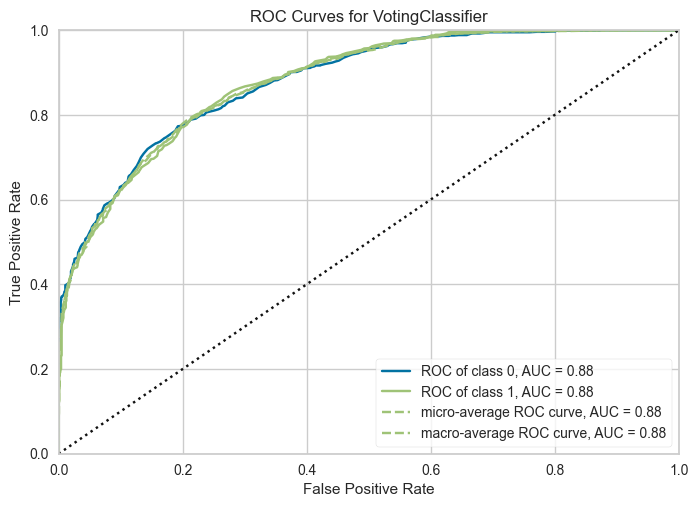

In [61]:
plot_model(blended1)

In [62]:
pred_holdout = predict_model(blended2)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7859,0.8748,0.8507,0.7726,0.8098,0.5662,0.5696


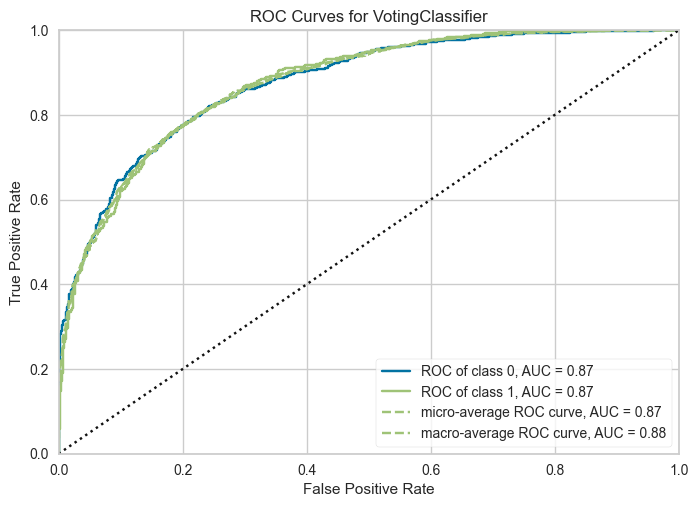

In [63]:
plot_model(blended2)

In [64]:
pred_holdout = predict_model(blended3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7814,0.8605,0.8566,0.7641,0.8077,0.5565,0.5614


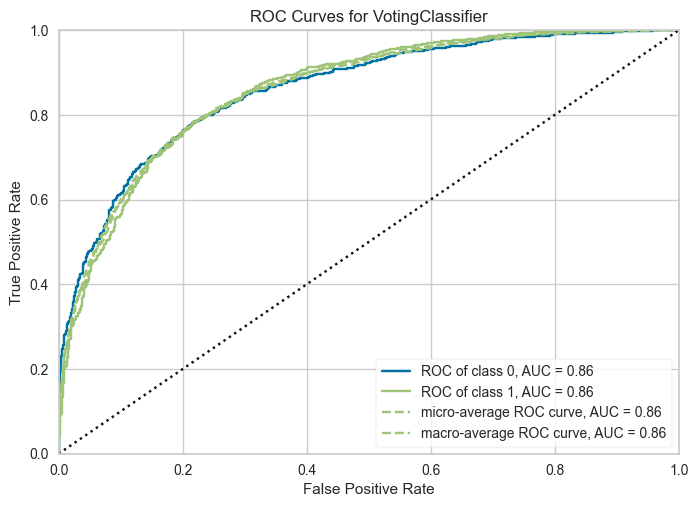

In [65]:
plot_model(blended3)

In [66]:
pred_holdout = predict_model(blended4)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7850,0.8774,0.8516,0.7710,0.8093,0.5643,0.5679


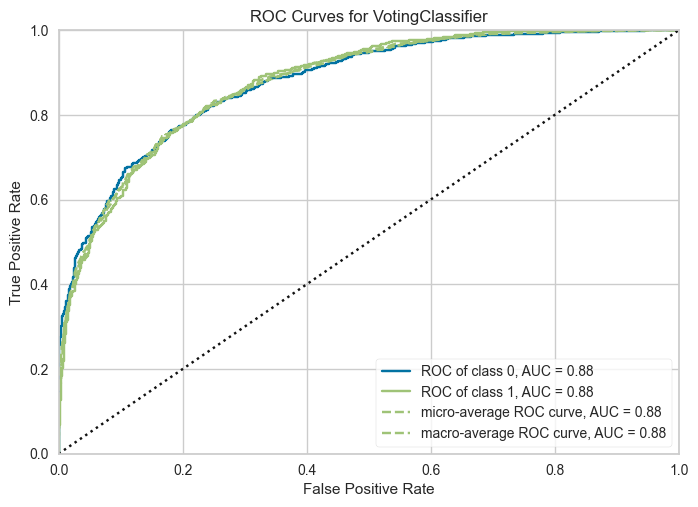

In [67]:
plot_model(blended4)

In [68]:
final_model = finalize_model(blended1)
predictions = predict_model(final_model, data = test)
predictions.loc[predictions['Label'] == 0, 'Score'] = 1 - predictions.loc[predictions['Label'] == 0, 'Score']
submission = pd.read_csv('./data/sample_submission.csv')
sub = predictions['Score']
submission['nerdiness'] = sub
submission.to_csv("./submit/submit14_1.csv", index = False)

In [69]:
final_model = finalize_model(blended2)
predictions = predict_model(final_model, data = test)
predictions.loc[predictions['Label'] == 0, 'Score'] = 1 - predictions.loc[predictions['Label'] == 0, 'Score']
submission = pd.read_csv('./data/sample_submission.csv')
sub = predictions['Score']
submission['nerdiness'] = sub
submission.to_csv("./submit/submit14_2.csv", index = False)

In [70]:
final_model = finalize_model(blended3)
predictions = predict_model(final_model, data = test)
predictions.loc[predictions['Label'] == 0, 'Score'] = 1 - predictions.loc[predictions['Label'] == 0, 'Score']
submission = pd.read_csv('./data/sample_submission.csv')
sub = predictions['Score']
submission['nerdiness'] = sub
submission.to_csv("./submit/submit14_3.csv", index = False)

In [ ]:
final_model = finalize_model(blended4)
predictions = predict_model(final_model, data = test)
predictions.loc[predictions['Label'] == 0, 'Score'] = 1 - predictions.loc[predictions['Label'] == 0, 'Score']
submission = pd.read_csv('./data/sample_submission.csv')
sub = predictions['Score']
submission['nerdiness'] = sub
submission.to_csv("./submit/submit14_4.csv", index = False)